In [1]:
import xarray as xr

data_path = "data/1month_anomaly_Global_ea_2t_201907_1991-2020_v02.grib"
data = xr.open_dataset(data_path, engine="cfgrib")

data

<xarray.Dataset>
Dimensions:     (latitude: 721, longitude: 1440)
Coordinates:
    number      int64 ...
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time  datetime64[ns] ...
Data variables:
    t2m         (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-06-26T17:08 GRIB to CDM+CF via cfgrib-0.9.1...

Xarray is very usefull python library. We can see, that after opening of the dataset, we can see Dimensions, Coordinates, Data variables and Attributes. Each of these elements contain useful information about our data. As we can see, we have two dimensions - `latitude` and `longitude`. These dimensions are also coordinates for our data - meaning that every single point in our data must have unique combination of `latitude` and `longitude`. Coordinates `time, step, heightAboveGround` and `valid_time` have only one value - it is information that is valid for every single point in our underlying DataArray.
<br><br>
However, the most important data for us is stored in Data variables, in this case with key "t2m". This is our underlying DataArray that carries all the information about temperature. This DataArray must have exactly the shape of latitude x longitude - every element of "t2m" DataArray will contain specific combination of latitude and longitude.
<br><br>
To visualise this DataArray, we can simple call `data["t2m"].plot()`. Note that the data is stored in Kelvins, we will convert it to Degrees Celsius first.

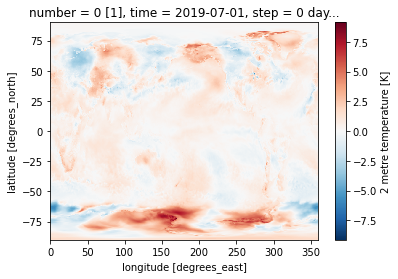

In [2]:
data["t2m"].plot()

This is basic visualisation that is done by xarray library. If we want to add borders, coastlines, meridians and parallels, we can use awesome Cartopy library. It is successor library of basemap, which had been replaced by Cartopy in 2016.

If we want to add more geospatial information to these images, we must start treating charts  as geographical maps - meaning that we will use longitude as values on x-axis and latitude as values on y-axis.

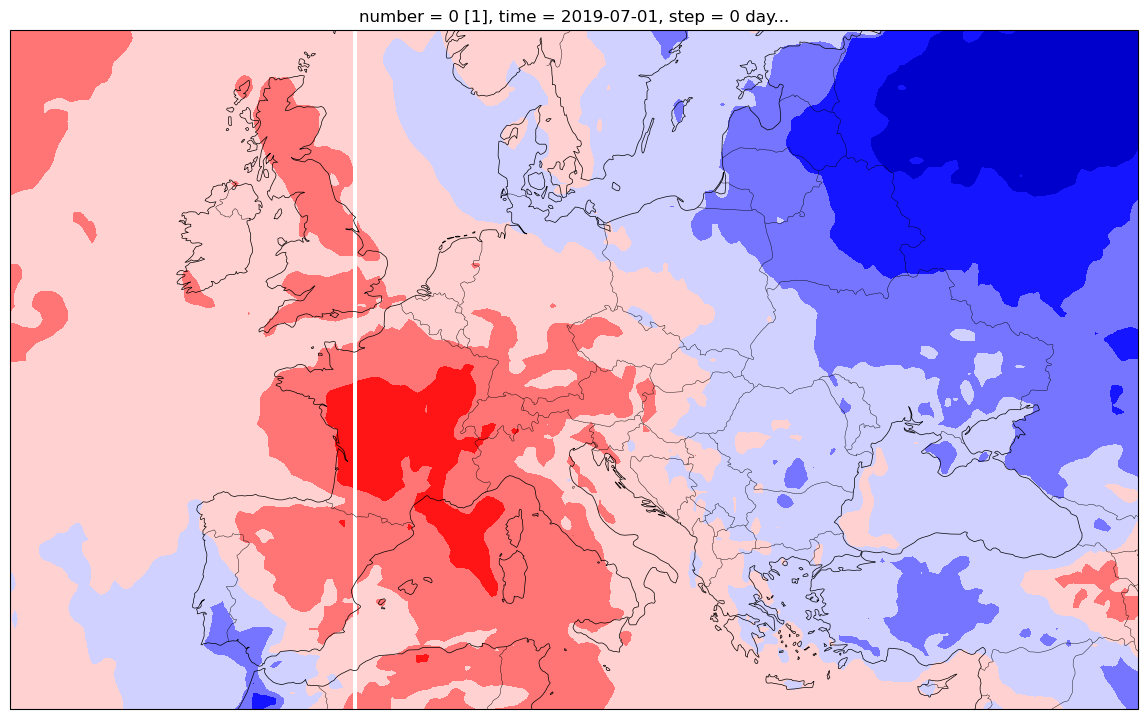

In [15]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd


# First we specify Coordinate Refference System for Map Projection
# We will use Mercator, which is a cylindrical, conformal projection. 
# It has ery large distortion at high latitudes, cannot 
# fully reach the polar regions.
crs = ccrs.Mercator()

# Now we will create axes object having projection of crs that we specified
plt.figure(figsize=(16,9), dpi=100)
ax = plt.axes(projection=crs, frameon=True)

# Draw gridlines
# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=.6, color='gray', alpha=0.5, linestyle='-.')
# gl.xlabel_style = {"size" : 7}
# gl.ylabel_style = {"size" : 7}

# To plot borders and coastlines, we can use cartopy feature
import cartopy.feature as cf
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)

# Now, we will specify extent of our map in minimum/maximum longitude/latitude
# Note that these values are specified in degrees of longitude and degrees of latitude
lon_min = -20
lon_max = 45
lat_min = 34
lat_max = 60

# # Since our projection is Mercator, which is specified as distance from meridian and equator 
# # in meters, we need to explicitly tell set_extent function, that provided extents are in degrees
# # That's why we need to use ccrs.PlateCarree() crs from cartopy.
# valid_time = data["t2m"].valid_time.values
# valid_time = pd.Timestamp(valid_time)
    

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
im = xr.plot.contourf(data["t2m"], cmap='seismic', add_colorbar=False, transform=ccrs.PlateCarree(),vmin=-5, vmax=5, levels=11, extent=[lon_min, lon_max, lat_min, lat_max])
# im = ax.imshow(data["t2m"], cmap="seismic", vmin=-5, vmax=5, transform=ccrs.PlateCarree(), origin = 'upper')
# cbar = plt.colorbar(im, ax=ax, shrink=.7)
# plt.title(data["t2m"].attrs.get("GRIB_name") + f" anomaly in {valid_time:%B %Y}")
plt.show()

This was very simple visualisation of Temperature Anomaly in July 2021 which was the hottest month ever recorded. In next article, we will talk about extents - how t owrite an algorithm that would always create extent having specific aspect ratio - to maintain the same image size when creating maps for multiple locations.

In [10]:
def adjust_longitude(dataset: xr.Dataset) -> xr.Dataset:
        """Swaps longitude coordinates from range (0, 360) to (-180, 180)

        Args:
            dataset (xr.Dataset): xarray Dataset

        Returns:
            xr.Dataset: xarray Dataset with swapped longitude dimensions
        """
        lon_name = "longitude"  # whatever name is in the data

        # Adjust lon values to make sure they are within (-180, 180)
        dataset["_longitude_adjusted"] = xr.where(
            dataset[lon_name] > 180, dataset[lon_name] - 360, dataset[lon_name]
        )
        dataset = (
            dataset.swap_dims({lon_name: "_longitude_adjusted"})
            .sel(**{"_longitude_adjusted": sorted(dataset._longitude_adjusted)})
            .drop(lon_name)
        )

        dataset = dataset.rename({"_longitude_adjusted": lon_name})
        return dataset
    
dataset = adjust_longitude(data)

if (
    dataset.coords["latitude"].attrs.get("stored_direction", False)
    == "decreasing"
    ):
    #     dataset = dataset.sel(
    #         latitude=slice(lat_max+model_resolution, lat_min-model_resolution), longitude=slice(lon_min-model_resolution, lon_max+model_resolution)
    #     )
    # else:
    #     dataset = dataset.sel(
    #         latitude=slice(lat_min-model_resolution, lat_max+model_resolution), longitude=slice(lon_min-model_resolution, lon_max+model_resolution)
    #     )
    dataset = dataset.sel(
        latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max)
    )
else:
    dataset = dataset.sel(
        latitude=slice(lat_min, lat_max), longitude=slice(lon_min, lon_max)
    )

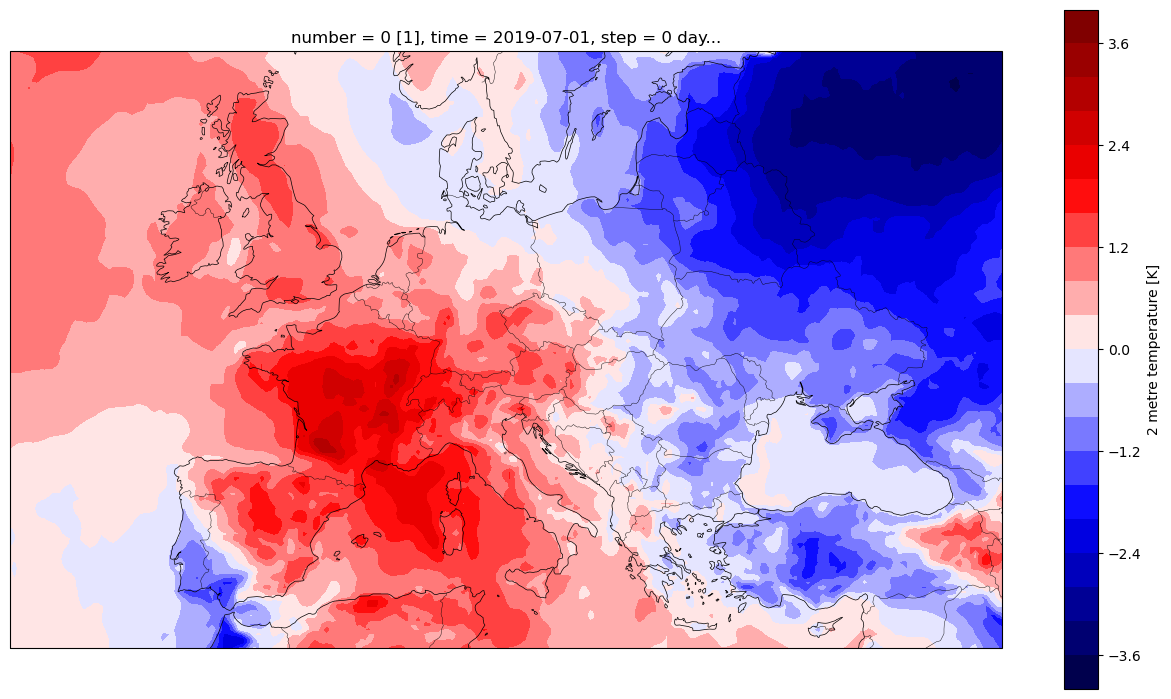

In [14]:
crs = ccrs.Mercator()
plt.figure(figsize=(16,9), dpi=100)
ax = plt.axes(projection=crs, frameon=True)
import cartopy.feature as cf
ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)
lon_min = -20
lon_max = 45
lat_min = 34
lat_max = 60
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

im = xr.plot.contourf(dataset["t2m"], cmap='seismic', transform=ccrs.PlateCarree(),center=0, levels=21)